In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import ode

In [2]:
# parameters

# k constants
k1 = 1.771*10**-3
k2 = 23295.0
k3 = 0.5
k4 = 1.0 
k5 = 0.8184
k6 = 0.5 
k7 = 0.2314 
k8 = 1.0 
k9 = 1.25 
k10 = 2.0
k11 = 2.795*10**-4
k12 = 33000.0
k13 = 0.5
k14 = 2.0 

# initial mole fractions
X10 = 0.1 
X20 = 0
X30 = 0.07
X40 = 0
X50 = 0.02

# initial conditions
PT0 = 114.7 # psia
TR0 = 353 # K
#TC0 = np.linspace(350, 400, 50) # K
TC0 = 350 

# more parameters
NT = 2500 # tubes
W = 100000 # lb/h
FcCpc = 10**6 # BTU/h degree C
dp = 0.25/12 # ft 
rhob = 100 # lb/ft3
eb = 0.5 # no units
mu = 0.048/3600 # lb/ft s 
Cp = 0.50 # BTU/lb degree C
U = 120.5 # BTU/h ft2 degree C

dt = 1/12 # ft
Ac = np.pi*(dt/2)**2 # ft2

dHr1 = -74.32*1000 # BTU/lbmol 
dHr2 = -474.57*1000 # BTU/lbmol 

# molecular weights
M1 = 46 # DT
M2 = 44 # VA
M3 = 32 # O2
M4 = 33 # CO2
M5 = 18 # H20

M = [M1, M2, M3, M4, M5]

MW0 = X10*M1 + X20*M2 + X30*M3 + X40*M4 +X50*M5 + (1-X10-X20-X30-X40-X50)*28

Rg = 10.731573*(9/5) # psia ft3/lbmol K

In [3]:
# calculate reaction rate 
def compute_r(S):

    X1, X2, X3, X4, X5, MW, TR, TC, PT = S
    
    PO2 = X3*PT 
    PDT = X1*PT
    PVA = X2*PT
    RT = ((1/TR)-(1/373))/1.987
    
    r1 = (k1*np.exp(-k2*RT)*(PO2**k3)*(PDT**k4))/(1+(k5*PO2**k6)+(k7*PDT**k8)+(k9*PVA**k10)) # lbmol/lbcat h
    r2 = (k11*np.exp(-k12*RT)*(PO2**k13)*(PVA**k14))/(1+(k5*PO2**k6)+(k7*PDT**k8)+(k9*PVA**k10)) # lbmol/lbcat h
    
    return [r1, r2]

In [4]:
# calculate net rate of reaction for each component
def compute_Ri(S): 
    
    r1, r2 = compute_r(S)
    
    R1 = -r1 
    R2 = r1 - r2
    R3 = -0.5*r1 - 2.5*r2
    R4 = 2*r2
    R5 = r1 + 2*r2
    
    return [R1,R2,R3,R4,R5]

In [5]:
# calculate superficial velocity
def compute_u(S):
    
    X1, X2, X3, X4, X5, MW, TR, TC, PT = S
    
    u = (359*14.7*W*TR)/(273*3600*NT*Ac*MW*PT)
    
    return u

In [6]:
# solve ODE using matrix method for cocurrent
def compute_dSdz(S, z):
    
    X1, X2, X3, X4, X5, MW, TR, TC, PT = S
    X = [X1, X2, X3, X4, X5]
    
    dSdz = np.zeros(len(S))
    R = compute_Ri(S)
    r1, r2 = compute_r(S)
    u = compute_u(S)
    
    pp = np.zeros(9)
    A = np.array([pp, pp, pp, pp, pp, pp, pp, pp, pp])
    
    for i in range(9):
        A[i,i] = 1
        
    for i in range(5):
        A[i,5] = -X[i]/MW
    
    for i in range(5):
        A[5, i] = 28 - M[i]
    
    b = np.zeros(9)
    
    for i in range(5): 
        b[i] = (NT*R[i]*rhob*Ac*MW)/W
    
    b[5] = 0 
    
    # calculate dSdz for TR
    b[6] = (-(NT*Ac*(r1*dHr1 + r2*dHr2)*rhob) - np.pi*NT*dt*U*(TR-TC))/(W*Cp)
    
    # calculate dSdz for TC
    b[7] = np.pi*NT*dt*U*(TR-TC)/FcCpc
    
    # calcualte dSdz for PT
    alpha = 1 + (2*dp)/(3*(1-eb)*dt) # find alpha value
    b[8] = (-(alpha**2)/(32.2*144)) * ((150*mu*u/dp**2)*((1-eb)**2/eb**3) + ((1.75*MW*(u**2))/(alpha*Rg*TR*dp))*((1-eb)/eb**3)*PT)
    
    dSdz = np.linalg.solve(A, b)
    
    return dSdz

In [7]:
# solve for countercurrent
def compute_dSdz_cc(S, z):
    
    dSdz = compute_dSdz(S,z)
    dSdz[7] = -dSdz[7]
    
    return dSdz

In [58]:
def solve_countercurrent(TC0,z_span):
    
    #z_span = np.linspace(0, 20, 10)
    
    num_iter = 1000
    epsilon = 0.001
    beta = 2
    delta_T = 5 # K 
    
    TC = TC0 + delta_T # guess a TC final for countercurrent 
    Szero = [X10, X20, X30, X40, X50, MW0, TR0, TC, PT0]
    solution_cc = odeint(compute_dSdz_cc, Szero, z_span) # solve countercurrent from left to right
        
    #print(solution_cc[:,7])
    
    diff = solution_cc[-1,7] - TC0
    #print(f"Iteration 0: = {diff}")
    
    if (abs(diff) <= epsilon):
        return solution_cc
    
    i = 1
    while (abs(diff) > epsilon):
        if (i>num_iter):
            return -1
        if (diff > 0):
            delta_T = delta_T - delta_T/beta * abs(diff)
        else:
            delta_T = delta_T + delta_T/beta * abs(diff)
            
        TC = TC0 + delta_T # guess a TC final for countercurrent 
        Szero = [X10, X20, X30, X40, X50, MW0, TR0, TC, PT0]
        solution_cc = odeint(compute_dSdz_cc, Szero, z_span) # solve countercurrent from left to right
        #print(solution_cc[:,7])
        
        diff = solution_cc[-1,7] - TC0
        #print(f"Iteration {i}: diff = {diff}")
        i = i + 1
        
    return solution_cc


In [9]:
# Plot TR_max vs TC0 and slope vs TC0
def plot_TR_max_slope_vs_TC0(TR_max, slope, TC0_values, type):
    
    # Plot TR max vs TC0
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(TC0_values, TR_max, color='blue')
    plt.title(f'Max T$_R$ vs T$_C$0, {type} flow')
    plt.xlabel('T$_C$0 (K)')
    plt.ylabel('T$_R$ max (K)')

    # Plot Sensitivity vs TC0 
    plt.subplot(1,2,2)
    plt.plot(TC0_values, slope, color='blue')
    plt.title(f'Reactor Sensitivity, {type} flow')
    plt.xlabel('T$_C$0 (K)')
    plt.ylabel('Sensitivity')

    plt.show()

In [10]:
# Plot TR vs z for different values of TC0
def plot_TR_vs_z(z,TR,TC0_values, type):
    
    for i in range(len(TC0_values)):
        plt.plot(z, TR[i], label=f'T$_C$0 = {TC0_values[i]} (K)')

    plt.title(f'T$_R$ vs z at different T$_C$0, {type} coolant flow')
    plt.xlabel('z (ft)')
    plt.ylabel('T$_R$ (K)')
    plt.legend(loc='best')
    plt.show()

In [11]:
# Plot TC vs z for different TC0
def plot_TC_vs_z(z, TC, TC0_values, type):

    for i in range(len(TC0_values)):
        plt.plot(z, TC[i], label=f'T$_C$0 = {TC0_values[i]} (K)')

    plt.title(f'T$_C$ vs z at different T$_C$0, {type} coolant flow')
    plt.xlabel('z (ft)')
    plt.ylabel('T$_C$ (K)')
    plt.legend(loc='best')
    plt.show()

In [12]:
# Plot mole fractions vs z at different TC0 
def plot_Xi_vs_z(z, Xi, TC0_values, flow_type, Xi_type):
    
    for i in range(len(TC0_values)): 
        plt.plot(z, Xi[i], label=f'T$_C$0 = {TC0_values[i]} (K)')
        
    plt.title(f'Mole fraction {Xi_type} vs z at different T$_C$0, {flow_type} coolant flow')
    plt.xlabel('z (ft)')
    plt.ylabel(f'Mole fraction {Xi_type}')
    plt.legend(loc='best')
    plt.show()

In [13]:
# checking to see if a dSdz was calculated
Szero = [X10, X20, X30, X40, X50, MW0, TR0, TC0, PT0]

dSdz = compute_dSdz(Szero, 0)
#print(dSdz)

In [14]:
# solve dSdz using odeint
z_span = np.linspace(0, 20, 10)

Szero = [X10, X20, X30, X40, X50, MW0, TR0, TC0, PT0]

solution_co = odeint(compute_dSdz, Szero, z_span)
#print(solution_co[:,7])
    
#solve_countercurrent()
#solution_cc = solve_countercurrent(TC0)
#print(solution_cc[:,7])

In [15]:
# Max reactor temperature vs initial coolant temperature
def compute_TR_max_vs_TC0_cocurrent():
    
    z_span = np.linspace(0, 20, 10)

    # Compute the solution for multiple values of TC0
    TC_pts = 100
    TC_values = np.linspace(TC0, 361.61, TC_pts)

    TR_max = np.zeros(TC_pts)

    for i in range(TC_pts):
        Szero[7] = TC_values[i]
    
        sol = odeint(compute_dSdz, Szero, z_span)
        TR_z = sol[:,6]
        TR_max[i] = TR_z[9]

    slope = np.gradient(TR_max, TC_values) # calculate sensitivty using derivative for countercurrent 

    # Plot figure
    plot_TR_max_slope_vs_TC0(TR_max, slope, TC_values, 'cocurrent')

In [16]:
# Reactor temperature as a function of position at multiple initial coolant temp
def compute_TR_vs_z_cocurrent():
    
    z_span = np.linspace(0, 20, 100)

    TC_pts = 5
    TC_values = np.linspace(TC0, 362, TC_pts)

    TR_z = np.zeros((TC_pts, len(z_span)))

    for i in range(TC_pts):
        Szero[7] = TC_values[i]
    
        sol = odeint(compute_dSdz, Szero, z_span)
        TR_z[i] = sol[:,6]
    
    plot_TR_vs_z(z_span, TR_z, TC_values, 'cocurrent')

In [17]:
# Coolant temperature as a function of position at multiple initial coolant temp
def compute_TC_vs_z_cocurrent():
    
    z_span = np.linspace(0, 20, 100)

    TC_pts = 5
    TC_values = np.linspace(TC0, 362, TC_pts)

    TC_z = np.zeros((TC_pts, len(z_span)))

    for i in range(TC_pts):
        Szero[7] = TC_values[i]
    
        sol = odeint(compute_dSdz, Szero, z_span)
        TC_z[i] = sol[:,7]

    plot_TC_vs_z(z_span, TC_z, TC_values, 'cocurrent')

In [18]:
# Yield/fractional conversion as a function of z
def compute_Xi_vs_z_cocurrent():
    z_span = np.linspace(0, 20, 100)

    TC_pts = 3
    TC_values = np.linspace(TC0, 362, TC_pts)

    label = ['DA', 'VA', 'O2', 'CO2', 'H2O']

    X1 = np.zeros((TC_pts, len(z_span)))
    X2 = np.zeros((TC_pts, len(z_span)))
    X3 = np.zeros((TC_pts, len(z_span)))
    X4 = np.zeros((TC_pts, len(z_span)))
    X5 = np.zeros((TC_pts, len(z_span)))

    for i in range(TC_pts):
        Szero[7] = TC_values[i]
    
        sol = odeint(compute_dSdz, Szero, z_span)
    
        X1[i] = sol[:,0]
        X2[i] = sol[:,1]
        X3[i] = sol[:,2]
        X4[i] = sol[:,3]
        X5[i] = sol[:,4]
    
    plot_Xi_vs_z(z_span, X1, TC_values, 'cocurrent', label[0])    
    plot_Xi_vs_z(z_span, X2, TC_values, 'cocurrent', label[1])    
    plot_Xi_vs_z(z_span, X3, TC_values, 'cocurrent', label[2])    
    plot_Xi_vs_z(z_span, X4, TC_values, 'cocurrent', label[3])    
    plot_Xi_vs_z(z_span, X5, TC_values, 'cocurrent', label[4])       

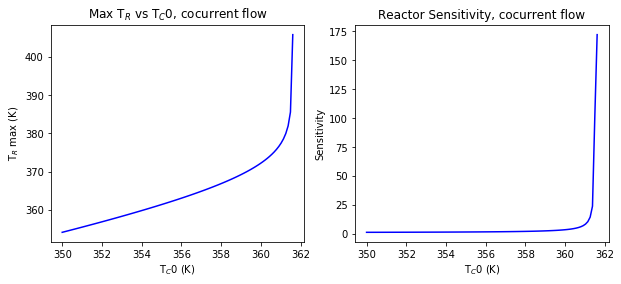

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


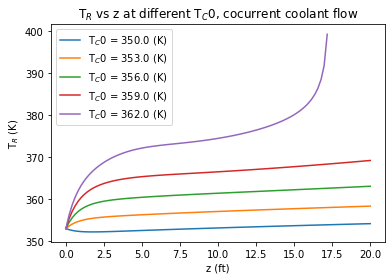

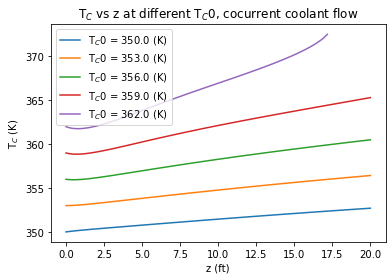

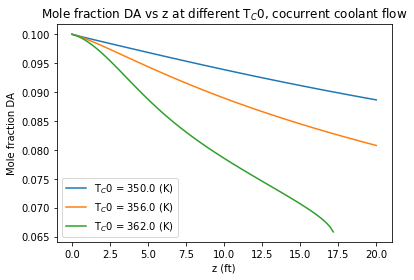

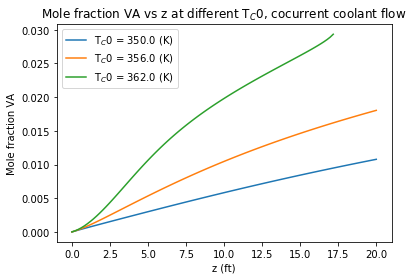

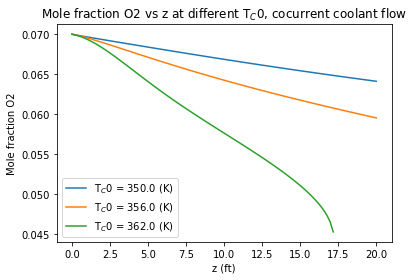

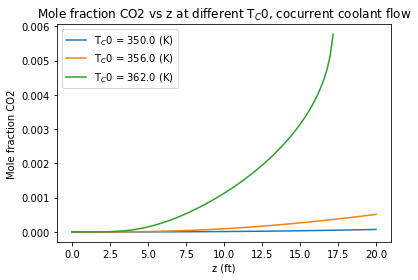

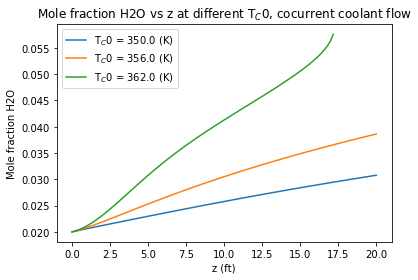

In [19]:
compute_TR_max_vs_TC0_cocurrent()
compute_TR_vs_z_cocurrent()
compute_TC_vs_z_cocurrent()
compute_Xi_vs_z_cocurrent()

In [77]:
# Max reactor temperature vs initial coolant temperature
def compute_TR_max_vs_TC0_countercurrent():

    z_span = np.linspace(0, 20, 10)

    # Compute the solution for multiple values of TC0
    TC_pts = 100
    TC_values = np.linspace(TC0, 358, TC_pts)

    TR_max = np.zeros(TC_pts)

    for i in range(TC_pts):
        Szero[7] = TC_values[i]
    
        sol = solve_countercurrent(TC_values[i], z_span)
        TR_z = sol[:,6]
        TR_max[i] = np.max(TR_z)

    slope = np.gradient(TR_max, TC_values) # calculate sensitivty using derivative for countercurrent 

    # Plot figure
    plot_TR_max_slope_vs_TC0(TR_max, slope, TC_values, 'countercurrent')

In [78]:
# Reactor temperature as a function of position at multiple initial coolant temp
def compute_TR_vs_z_countercurrent():
    
    z_span = np.linspace(0, 20, 100)

    TC_pts = 5
    TC_values = np.linspace(TC0, 358.5, TC_pts)

    TR_z = np.zeros((TC_pts, len(z_span)))

    for i in range(TC_pts):
        Szero[7] = TC_values[i]
    
        sol = solve_countercurrent(TC_values[i], z_span)
        TR_z[i] = sol[:,6]
    
    plot_TR_vs_z(z_span, TR_z, TC_values, 'countercurrent')

In [79]:
# Coolant temperature as a function of position at multiple initial coolant temp
def compute_TC_vs_z_countercurrent():
    
    z_span = np.linspace(0, 20, 100)

    TC_pts = 5
    TC_values = np.linspace(TC0, 357.94, TC_pts)

    TC_z = np.zeros((TC_pts, len(z_span)))

    for i in range(TC_pts):
        Szero[7] = TC_values[i]
    
        sol = solve_countercurrent(TC_values[i], z_span)
        TC_z[i] = sol[:,7]

    plot_TC_vs_z(z_span, TC_z, TC_values, 'countercurrent')

In [80]:
# Yield/fractional conversion as a function of z
def compute_Xi_vs_z_coountercurrent():
    z_span = np.linspace(0, 20, 100)

    TC_pts = 3
    TC_values = np.linspace(TC0, 358, TC_pts)

    label = ['DA', 'VA', 'O2', 'CO2', 'H2O']

    X1 = np.zeros((TC_pts, len(z_span)))
    X2 = np.zeros((TC_pts, len(z_span)))
    X3 = np.zeros((TC_pts, len(z_span)))
    X4 = np.zeros((TC_pts, len(z_span)))
    X5 = np.zeros((TC_pts, len(z_span)))

    for i in range(TC_pts):
        Szero[7] = TC_values[i]
    
        sol = solve_countercurrent(TC_values[i], z_span)
    
        X1[i] = sol[:,0]
        X2[i] = sol[:,1]
        X3[i] = sol[:,2]
        X4[i] = sol[:,3]
        X5[i] = sol[:,4]
    
    plot_Xi_vs_z(z_span, X1, TC_values, 'countercurrent', label[0])    
    plot_Xi_vs_z(z_span, X2, TC_values, 'countercurrent', label[1])    
    plot_Xi_vs_z(z_span, X3, TC_values, 'countercurrent', label[2])    
    plot_Xi_vs_z(z_span, X4, TC_values, 'countercurrent', label[3])    
    plot_Xi_vs_z(z_span, X5, TC_values, 'countercurrent', label[4])   

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


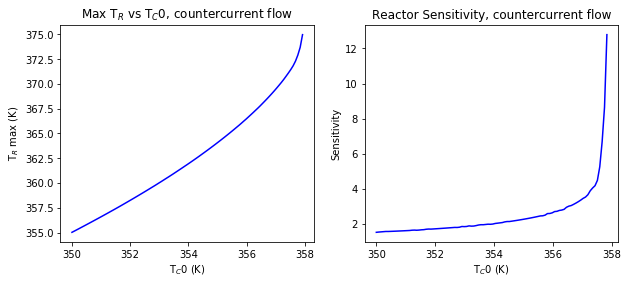

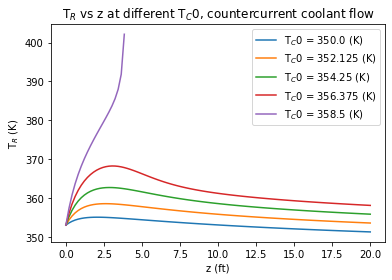

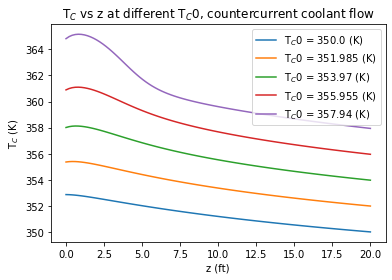

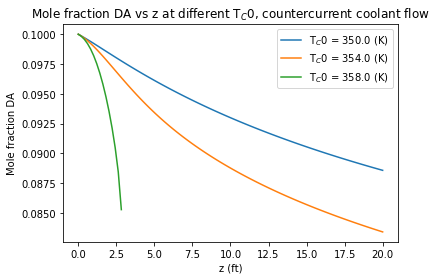

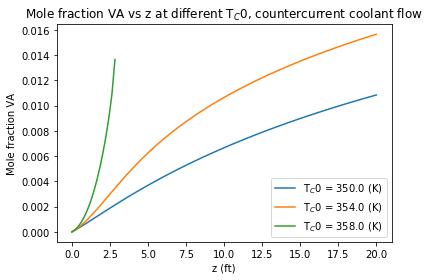

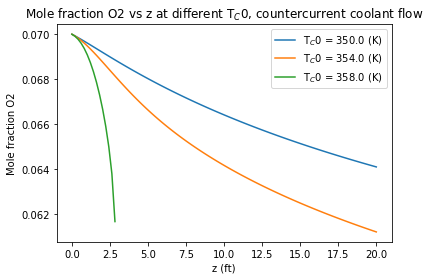

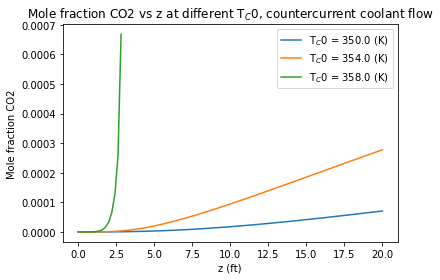

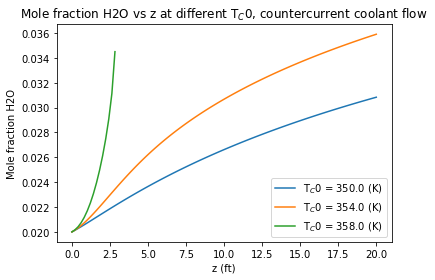

In [81]:
compute_TR_max_vs_TC0_countercurrent()
compute_TR_vs_z_countercurrent()
compute_TC_vs_z_countercurrent()
compute_Xi_vs_z_coountercurrent()

In [85]:
z_span = np.linspace(0, 20, 10)

# Compute the solution for multiple values of TC0
TC_pts = 100
TC0_values = np.linspace(TC0, 361.61, TC_pts)

TR_max_co = np.zeros(TC_pts)
TR_max_cc = np.zeros(TC_pts)

for i in range(TC_pts):
    Szero[7] = TC_values[i]
    
    sol_co = odeint(compute_dSdz, Szero, z_span)
    TR_z_co = sol_co[:,6]
    TR_max_co[i] = TR_z_co[9]
    
    sol_cc = solve_countercurrent(TC0_values[i], z_span)
    TR_z_cc = sol_cc[:,6]
    TR_max_cc[i] = np.max(TR_z_cc)

slope_co = np.gradient(TR_max_co, TC0_values) # calculate sensitivty using derivative for cocurrent 
slope_cc = np.gradient(TR_max_cc, TC0_values) # calculate sensitivty using derivative for countercurrent 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


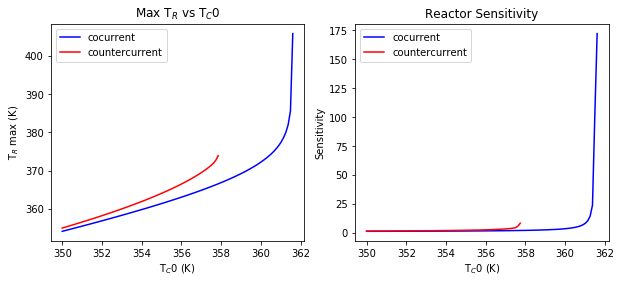

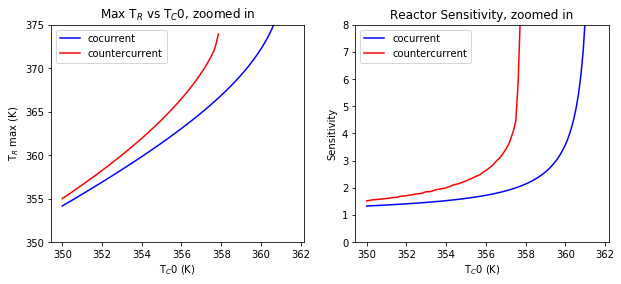

In [93]:
# Plot TR max vs TC0
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(TC0_values, TR_max_co, color='blue', label='cocurrent')
plt.plot(TC0_values, TR_max_cc, color='red', label='countercurrent')
plt.title(f'Max T$_R$ vs T$_C$0')
plt.xlabel('T$_C$0 (K)')
plt.ylabel('T$_R$ max (K)')
plt.legend(loc='best')

# Plot Sensitivity vs TC0 
plt.subplot(1,2,2)
plt.plot(TC0_values, slope_co, color='blue', label='cocurrent')
plt.plot(TC0_values, slope_cc, color='red', label='countercurrent')
plt.title(f'Reactor Sensitivity')
plt.xlabel('T$_C$0 (K)')
plt.ylabel('Sensitivity')
plt.legend(loc='best')

# Zoom in
# Plot TR max vs TC0
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(TC0_values, TR_max_co, color='blue', label='cocurrent')
plt.plot(TC0_values, TR_max_cc, color='red', label='countercurrent')
#plt.xlim(350, 362)
plt.ylim(350, 375)
plt.title(f'Max T$_R$ vs T$_C$0, zoomed in')
plt.xlabel('T$_C$0 (K)')
plt.ylabel('T$_R$ max (K)')
plt.legend(loc='best')

# Plot Sensitivity vs TC0 
plt.subplot(1,2,2)
plt.plot(TC0_values, slope_co, color='blue', label='cocurrent')
plt.plot(TC0_values, slope_cc, color='red', label='countercurrent')
plt.ylim(0, 8)
plt.title(f'Reactor Sensitivity, zoomed in')
plt.xlabel('T$_C$0 (K)')
plt.ylabel('Sensitivity')
plt.legend(loc='best')

plt.show()